In [1]:
from pathlib import Path
import json
import numpy as np
import h5py
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from dataloader import Custom3DShapesDataset
from model import CNNEncoder,CNNClassifier
from main import train_loop
from utils import show_images_grid, train_model,create_gif_from_dataset
from loss import BatchAllTtripletLoss

with open('config.json') as json_file:
    config = json.load(json_file)
    data_folder = Path(config['dataset']['basepath'])

    fig_path =  Path(config['reporting']['figpath'])

## Load the dataset

In [2]:
# load dataset

datafile = data_folder / '3dshapes.h5'

In [3]:
# Initialize the custom dataset
dataset = Custom3DShapesDataset(datafile)

# Split the dataset into train/ validation/ test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


# Create a PyTorch DataLoader for batching and shuffling
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes =  dataset._NUM_VALUES_PER_FACTOR['shape']
# resnet50_classifier = CNNClassifier(models.resnet50, num_classes).to(device)

latent_dim = 16
resnet50_encoder = CNNEncoder(models.resnet50, latent_dim).to(device)
# Train the model
criterion = BatchAllTtripletLoss()
optimizer = torch.optim.Adam(resnet50_encoder.parameters(), lr=0.001)

num_epochs = 1  # You can adjust the number of epochs as needed
# model,train_losses, val_losses = train_loop(resnet50_classifier, valloader,testloader, criterion, optimizer, device, num_epochs)

In [6]:
# Iterate through the dataloader
resnet50_encoder.train()
running_train_loss = 0.0
num_train_batches = 0
train_losses = []
for images, labels in trainloader:

    inputs = images.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    # outputs = resnet50_classifier(inputs)
    latents = resnet50_encoder(inputs)
    
    print(f"Batch of outputs shape: {latents.shape}")
    # Calculate the loss
    loss = criterion(latents, labels[:,-2].to(torch.long))
    
    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Update the running loss
    running_train_loss += loss.item()
    num_train_batches += 1
epoch_train_loss = running_train_loss / num_train_batches
train_losses.append(epoch_train_loss)
print(f"Epoch training loss: {epoch_train_loss:.4f}")

Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of outputs shape: torch.Size([32, 16])
Batch of o

KeyboardInterrupt: 

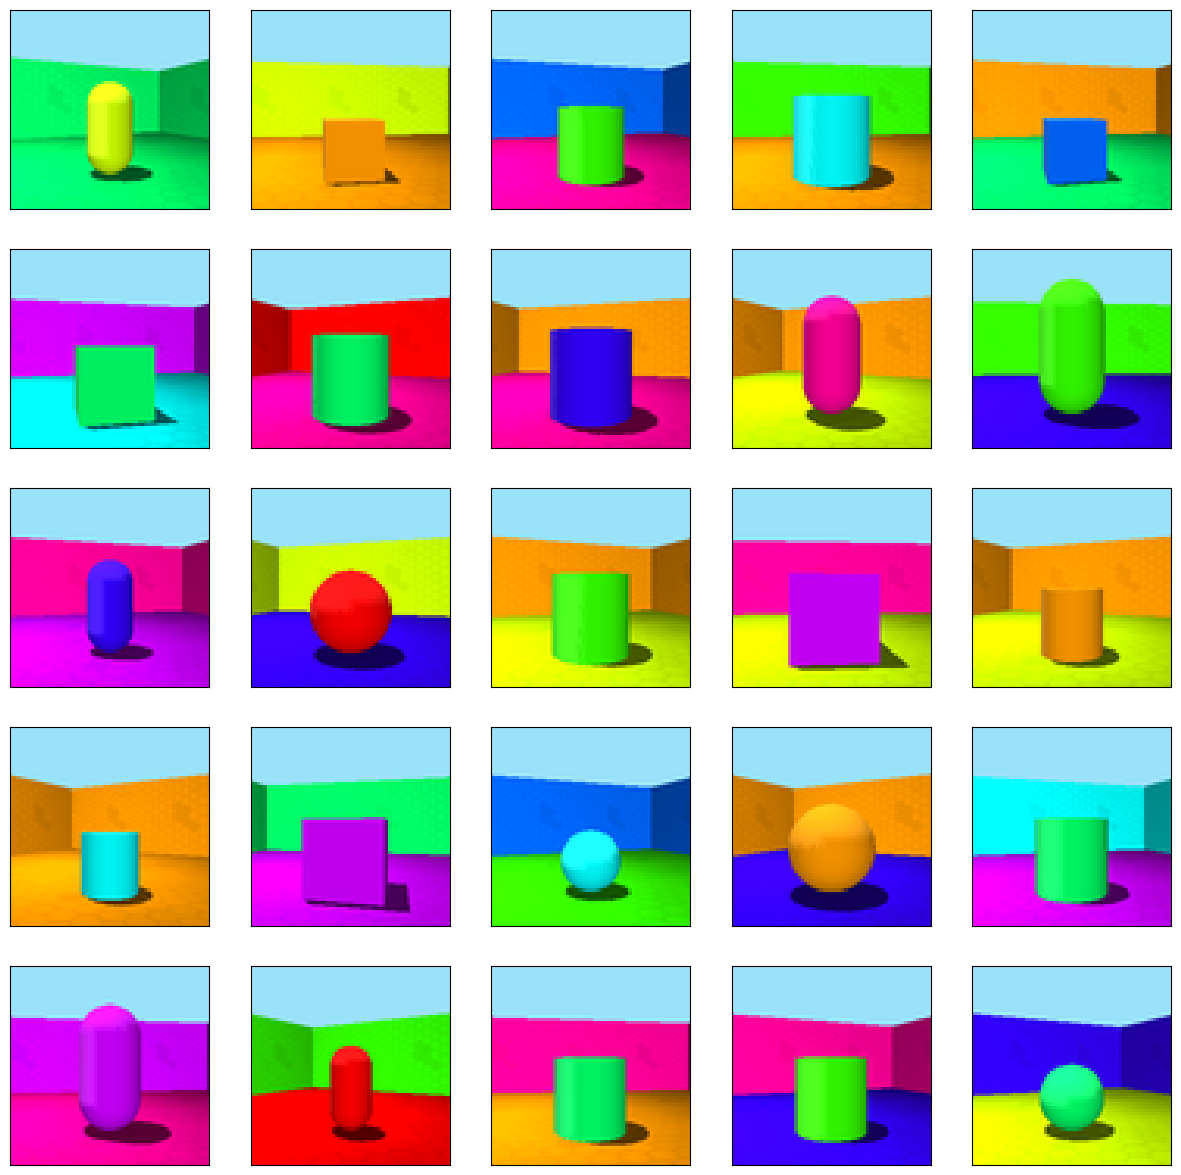

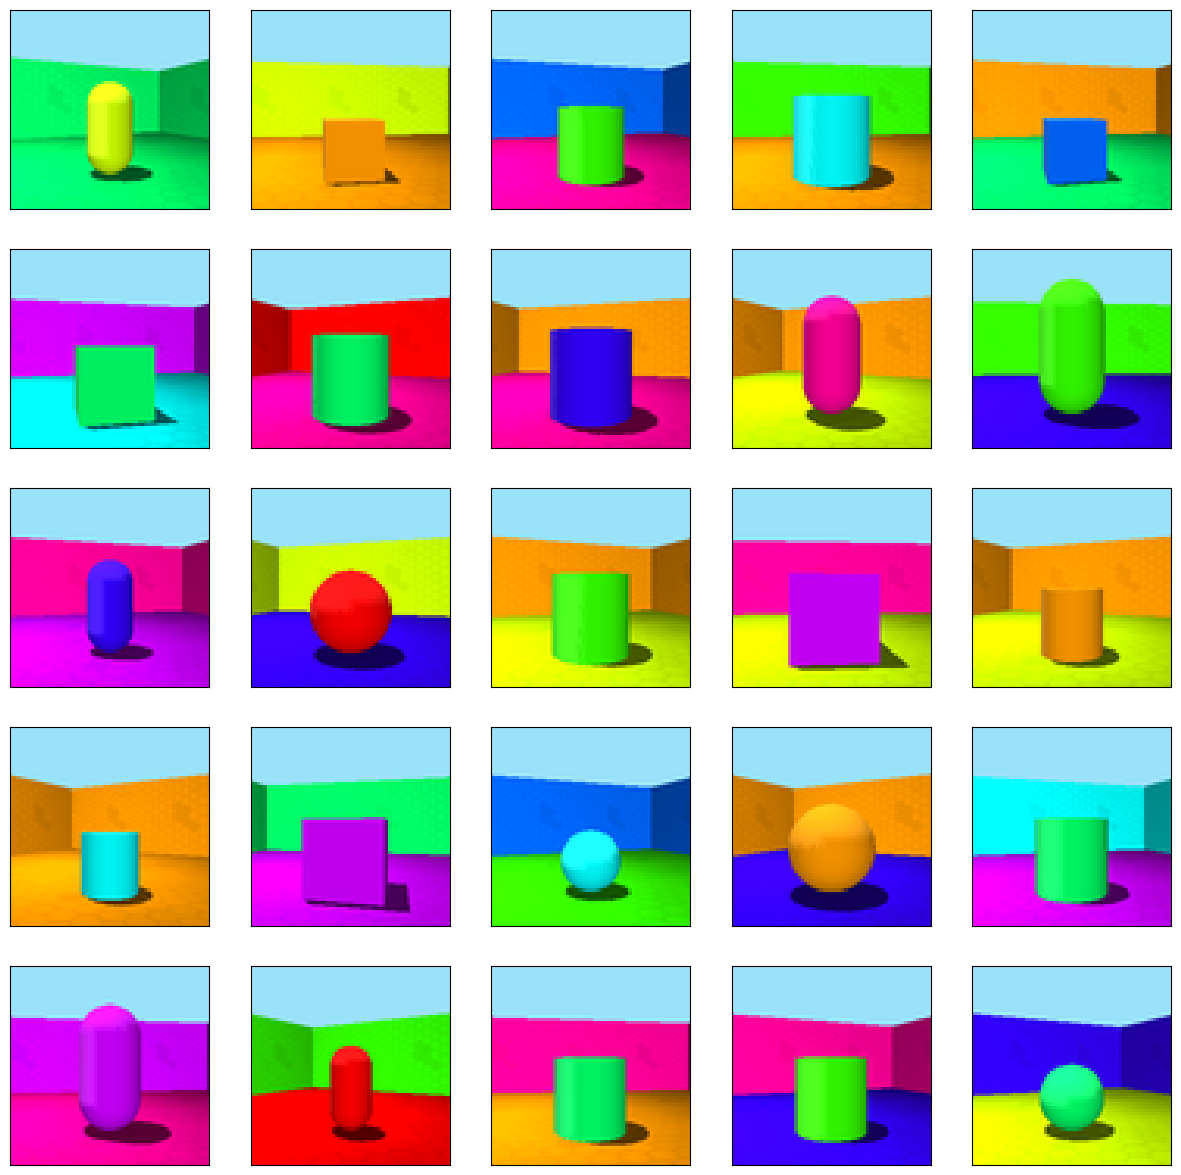

In [4]:
img_batch = dataset.sample_random_batch(batch_size)
show_images_grid(img_batch)

show_images_grid(img_batch, num_images=25, save_path=fig_path/"output_figure.png")

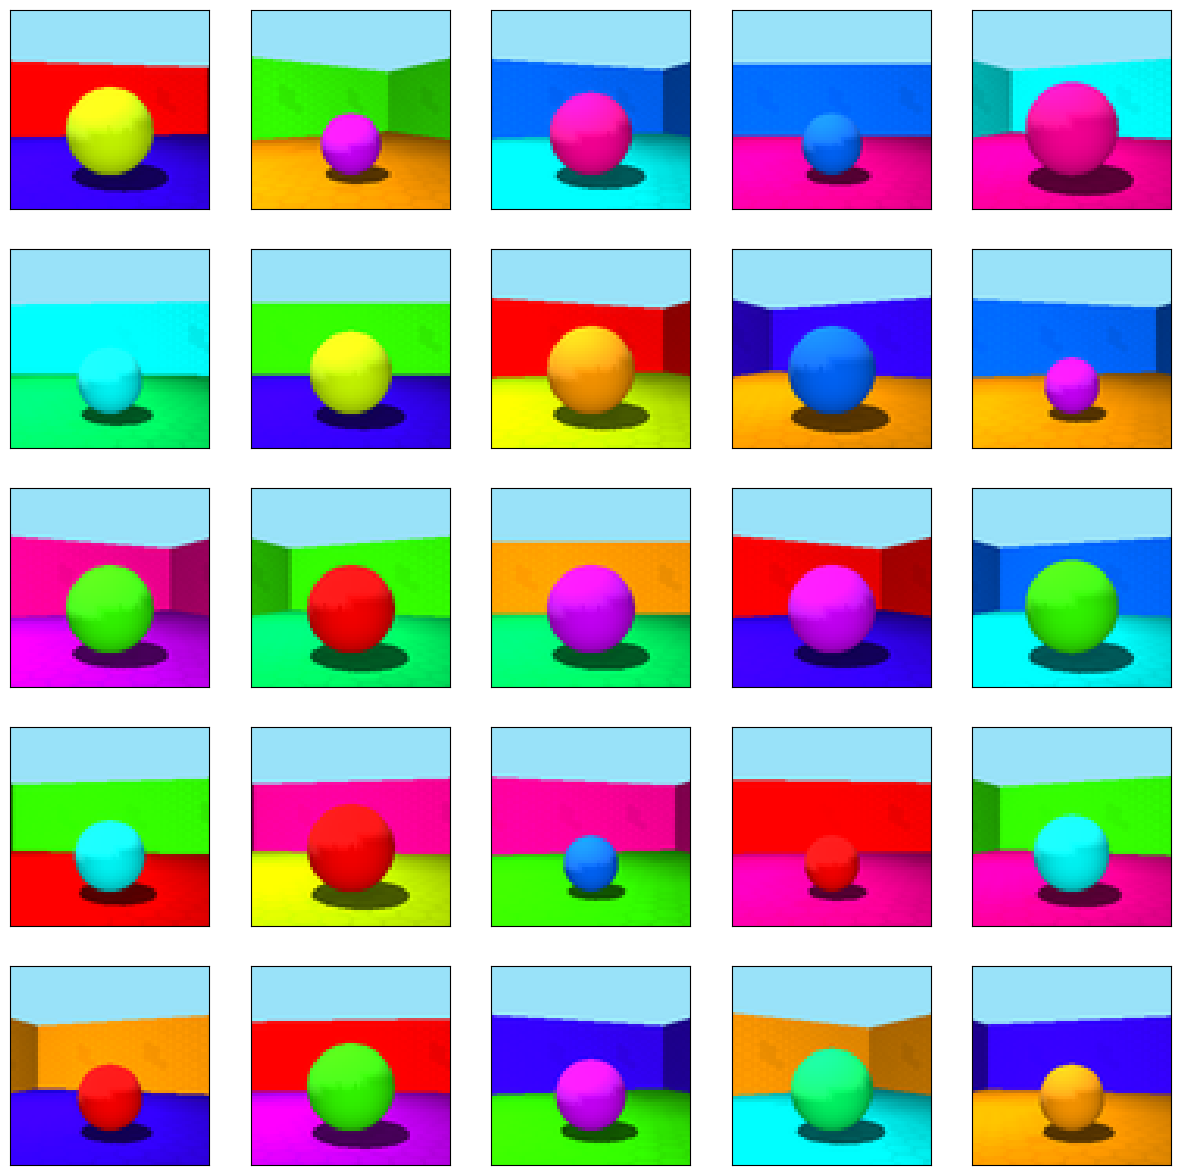

In [5]:
batch_size = 100
fixed_factor_str = 'shape' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 2  # first value of floor hue - red
fixed_factor = dataset._FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = dataset.sample_batch(batch_size, fixed_factor, fixed_factor_value)

show_images_grid(img_batch)

In [6]:
create_gif_from_dataset(dataset, 100, 'floor_hue', 0, './Figures/floor_hue.gif')

In [7]:
# Example usage with ResNet-50 as the backbone and latent_dim=128
latent_dim = 128
resnet50_encoder = CNNEncoder(models.resnet50, latent_dim)

In [8]:
# Iterate through the dataloader
for images, labels in trainloader:
    # Process your batch of images and labels here
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    features = resnet50_encoder(images)
    print("Output feature shape:", features.shape)
    shape_labels = labels[:, -2]
    print(f"Shape labels shape: {shape_labels.shape}")
    break  # Break the loop after one iteration for demonstration purposes



Batch of images shape: torch.Size([32, 3, 64, 64])
Batch of labels shape: torch.Size([32, 6])
Output feature shape: torch.Size([32, 128])
Shape labels shape: torch.Size([32])


In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_encoder.parameters(), lr=0.001)
trained_model, epoch_history, loss_history = train_model(resnet50_encoder, trainloader, criterion, optimizer, num_epochs=1, device='cuda')

Epoch 1/1, Loss: 0.03538733792802476
Training complete!
